# S&P 2019 Data Exploration Stage

**by Marc Angelo Acebedo**

# Table of Contents
- [Introduction](#introduction)
- [Data Setup & Overview](#setup)
- [Exploration](#explore)
    - [Univariate](#uni)
    - [Bivariate](#bi)
    - [Multivariate](#multi)


# I) Introduction <a id = "introduction"> </a>


- I kept features in separate CSVs because date formats differ. `eps_fc` and `eps_act` 

### After cleaning the original dataset as documented in my data wrangling process [here](TK) tk, I isolated the following columns:

`features.csv`
- **firm_id**

`avgs.csv`

## II) Data Setup & Overview<a id = "setup"></a> 

In [47]:
#import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random
import calendar

%matplotlib inline
plt.style.use('bmh')

In [3]:
#define data directories
PATH_CLEAN = './data/clean/'
PATH_CLEAN_AVGS = './data/clean/averages/'

In [4]:
#define visuals destination
PATH_UNIVARIATE = './visuals/univariate/'
PATH_BIVARIATE = './visuals/bivariate'
PATH_MULTIVARIATE = './visuals/multivariate'

**Import features and all averages**

In [5]:
features = pd.read_csv(PATH_CLEAN + 'features.csv', low_memory = False)
avgs = pd.read_csv(PATH_CLEAN_AVGS + 'avgs.csv')

In [6]:
#import firm_ids for foreign key references
firm_ids = pd.read_csv(PATH_CLEAN + 'firms.csv')

### Describe Datasets

In [7]:
#look at 5 random entries
features.sample(5)

,firm_id,feature,date,term,value
141051,188,eps_act,NaN,2003Q4,0.105
167195,499,eps_act,NaN,2008Q4,0.000
68505,326,eps_fc_terms,2001-01-01,2001Q2,1.152
148788,280,eps_act,NaN,2006Q1,0.110
90744,94,eps_fc,NaN,2006Q1,-0.030


In [8]:
avgs.sample(5)

,firm_id,average,average_type,time_period,feature
33929,94,NaN,yearly,2000,eps_fc_terms
40954,49,0.601250,yearly,2014,eps_fc_terms
4071,31,0.032250,yearly,2003,eps_fc
47807,337,0.286622,quarterly,q4,eps_act
42061,146,0.973000,yearly,2016,eps_fc_terms


In [9]:
print('FEATURES rows, columns = {}'.format(features.shape), '\n',
      'AVERAGES rows, columns = {}'.format(avgs.shape))

FEATURES rows, columns = (167660, 5) 
 AVERAGES rows, columns = (52015, 5)


### Convert DateTime columns

In [10]:
features.dtypes

firm_id      int64
feature     object
date        object
term        object
value      float64
dtype: object

In [11]:
features.date = pd.to_datetime(features.date)
features.term = pd.to_datetime(features.term).dt.to_period('Q')

In [12]:
#verify dtypes
features.dtypes

firm_id             int64
feature            object
date       datetime64[ns]
term        period[Q-DEC]
value             float64
dtype: object

In [13]:
avgs.dtypes

firm_id           int64
average         float64
average_type     object
time_period      object
feature          object
dtype: object

- kept **time_period** as an object bc column consists of varying DateTime formats

# III) Exploration <a id="explore"> </a>

## A) Univariate <a id = "uni"></a>

### MISSING VALUES (Features)

In [295]:
def generate_missing_total(df, title_name, save_path, csv_name):
    plt.figure(figsize = [10, 5])
    plt.title('Missing Values per Column under ' + title_name, size = 20)
    na_counts = df.isna().sum().sort_values(ascending = True)
    
    na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
    plt.xlabel('Count', size = 10)
    plt.ylabel('Column Name', size = 10)
    plt.savefig(save_path + csv_name)

In [296]:
features.isna().any()

firm_id    False
feature    False
date        True
term       False
value       True
dtype: bool

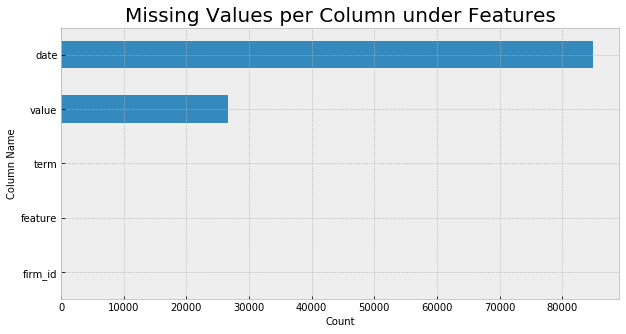

In [297]:
generate_missing_total(features, 'Features', PATH_UNIVARIATE, 'features-missing-total.png')

### MISSING VALUES (Averages)

In [298]:
avgs.isna().any()

firm_id         False
average          True
average_type    False
time_period      True
feature         False
dtype: bool

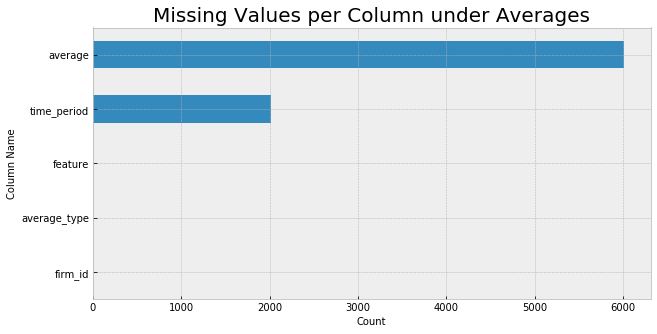

In [299]:
#averages
generate_missing_total(avgs, 'Averages', PATH_UNIVARIATE, 'avgs-missing-total.png')

### FIRM_ID (Features)

In [300]:
def generate_pct_bar(df, cat_var, color):
    cat_counts = df[cat_var].value_counts()
    ax = sb.countplot(data = df, y = cat_var, order = cat_counts.index, palette = color)
    
    n_points = df.shape[0]
    locs, labels = plt.yticks()
    
    for p in ax.patches:
        percentage = '{:0.1f}%'.format(100 * p.get_width()/n_points)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), size = 20)

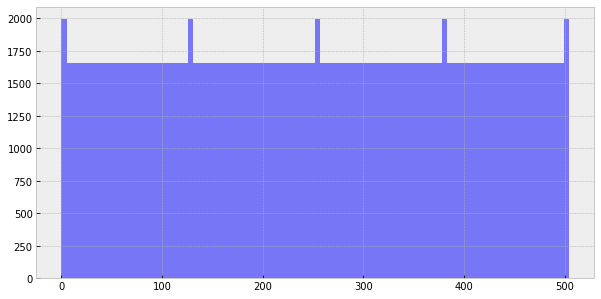

In [301]:
plt.figure(figsize = [10,5])
x = features.firm_id.values
num_bins = 100
n, bins, patches = plt.hist(x, num_bins, facecolor = 'blue', alpha = 0.5)
plt.show()

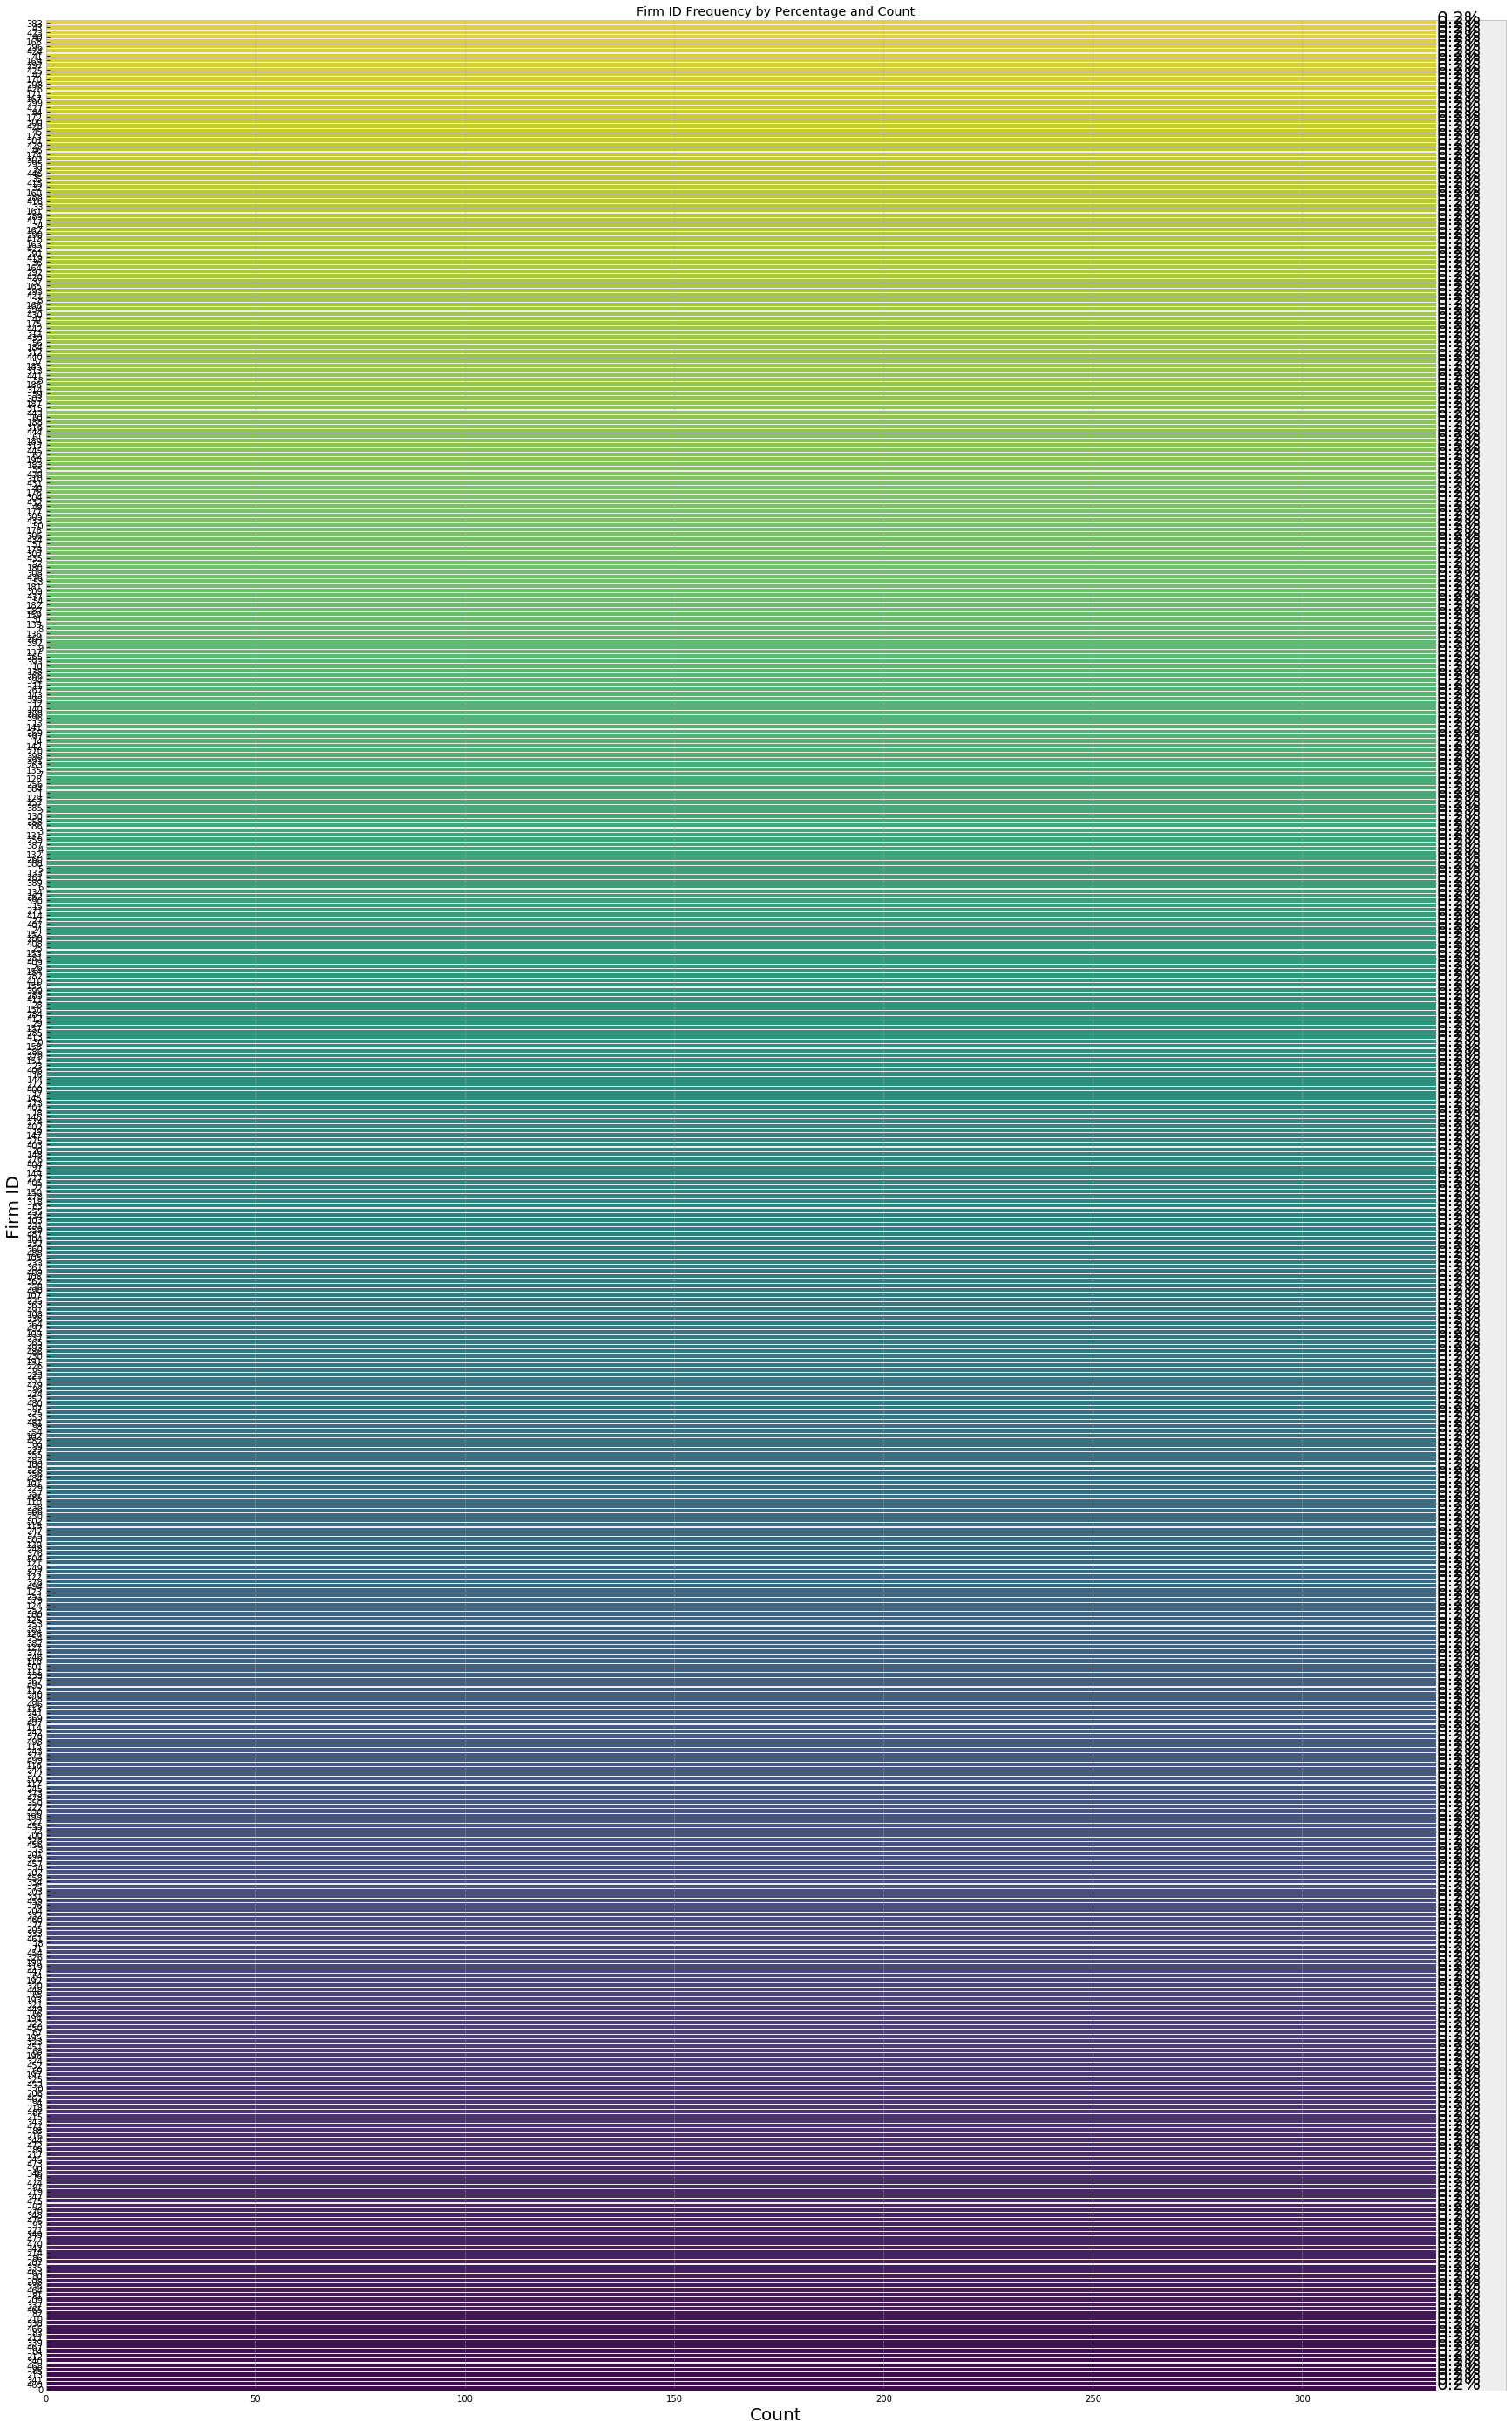

In [302]:
plt.figure(figsize = [30, 50])
generate_pct_bar(features, 'firm_id', 'viridis_r')
plt.title('Firm ID Frequency by Percentage and Count')
plt.xlabel ('Count', size = 20)
plt.ylabel('Firm ID', size = 20)
plt.savefig(PATH_UNIVARIATE + 'features-firm-ids-pct-count')

### FEATURE (Features)

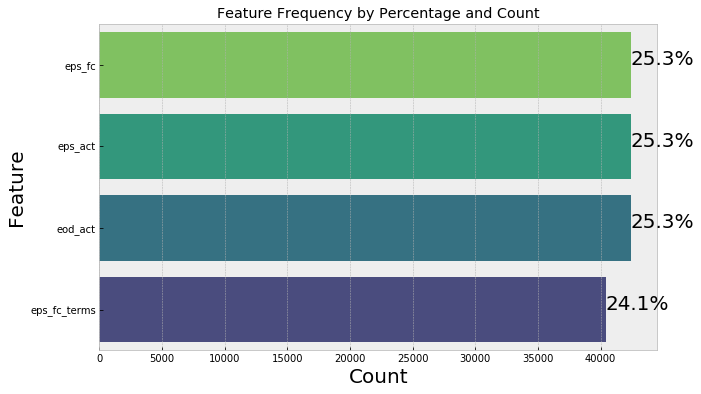

In [303]:
plt.figure(figsize = [10, 6])
generate_pct_bar(features, 'feature', 'viridis_r')
plt.title('Feature Frequency by Percentage and Count');
plt.xlabel('Count', size = 20)
plt.ylabel('Feature', size = 20)
plt.savefig(PATH_UNIVARIATE + 'features-feature-pct-count.png')

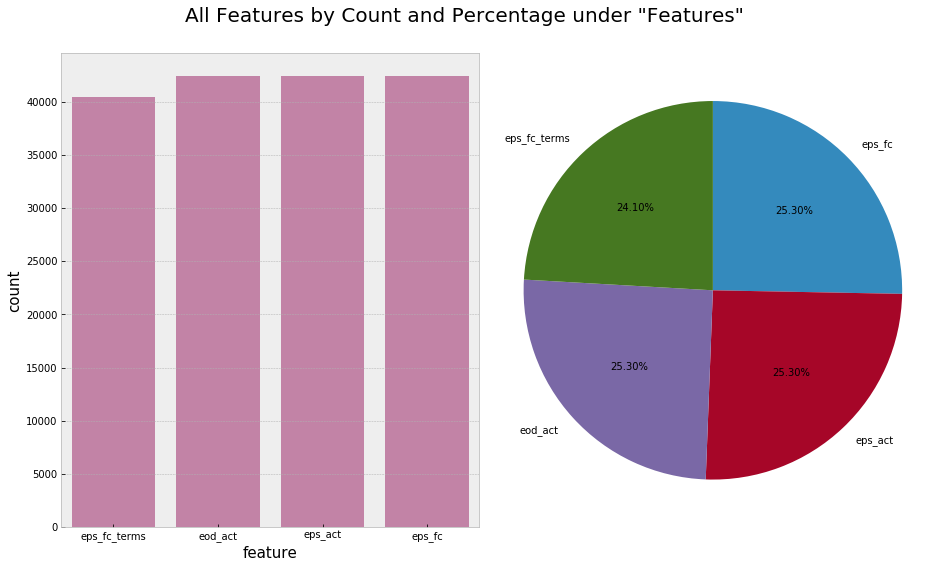

In [304]:
import itertools
plt.figure(figsize = [13, 8])

#set palette
base_color = sb.color_palette()[5]

#countplot
plt.subplot(1, 2, 1)
sb.countplot(data = features, x = 'feature', order = features.feature.value_counts(ascending = True).index,
            color = base_color)
frame = plt.gca()

#pie chart
plt.subplot(1, 2, 2)
sorted_counts = features['feature'].value_counts()
plt.pie(features.feature.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = features.feature.value_counts().index);
plt.axis('square');

#overall graphic
plt.suptitle('All Features by Count and Percentage under "Features"', size = 20)
plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.savefig(PATH_UNIVARIATE + 'features-feature-pct-count.png')


### DATE (Features)

In [306]:
features_years = features.date.dt.year.dropna().astype(int)
features_months = features.date.dt.month.dropna().astype(int)

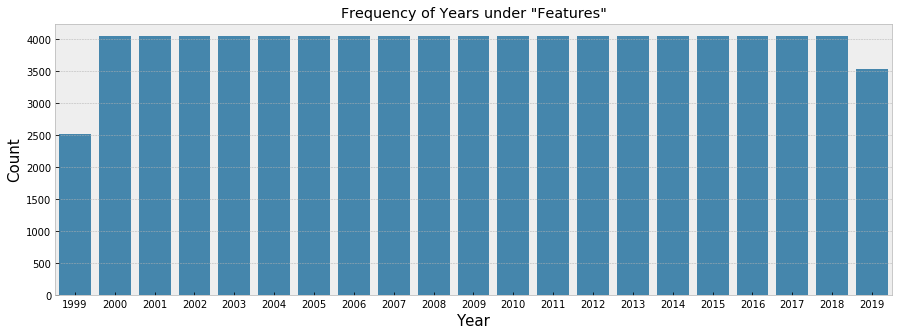

In [307]:
#years
plt.figure(figsize = [15, 5])
x = features_years
y = [i + random.gauss(0,1) for i, _ in enumerate(x)]

ax = sb.countplot(data = features, x = features_years, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Years under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-years-count.png')
plt.show()

In [308]:
#months
features_months = features_months.apply(lambda x: calendar.month_abbr[x])
months_order = ['Jan', 'Mar', 'Apr', 'Jun', 'Jul', 'Sep', 'Oct', 'Dec']

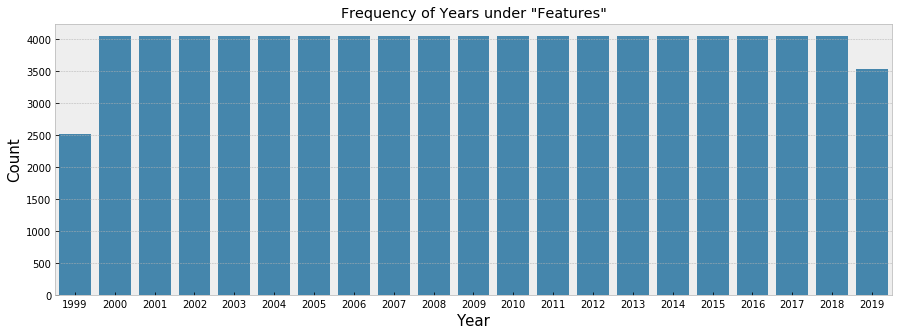

In [309]:
#years
plt.figure(figsize = [15, 5])

ax = sb.countplot(data = features, x = features_years, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Years under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-years-count.png')
plt.show()

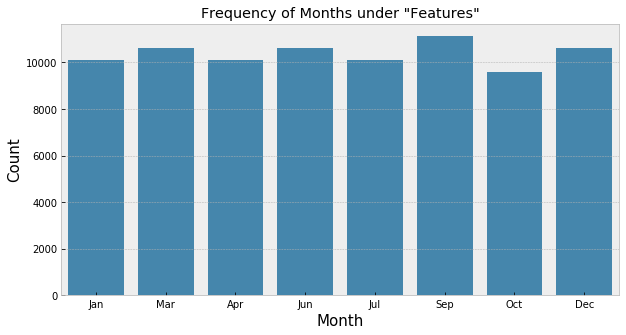

In [310]:
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features_months, color = sb.color_palette()[0], order = months_order)
ax.set(xlabel = 'Month', ylabel = 'Count')
ax.set_title('Frequency of Months under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-months-count.png')
plt.show();

### TERM (Features)

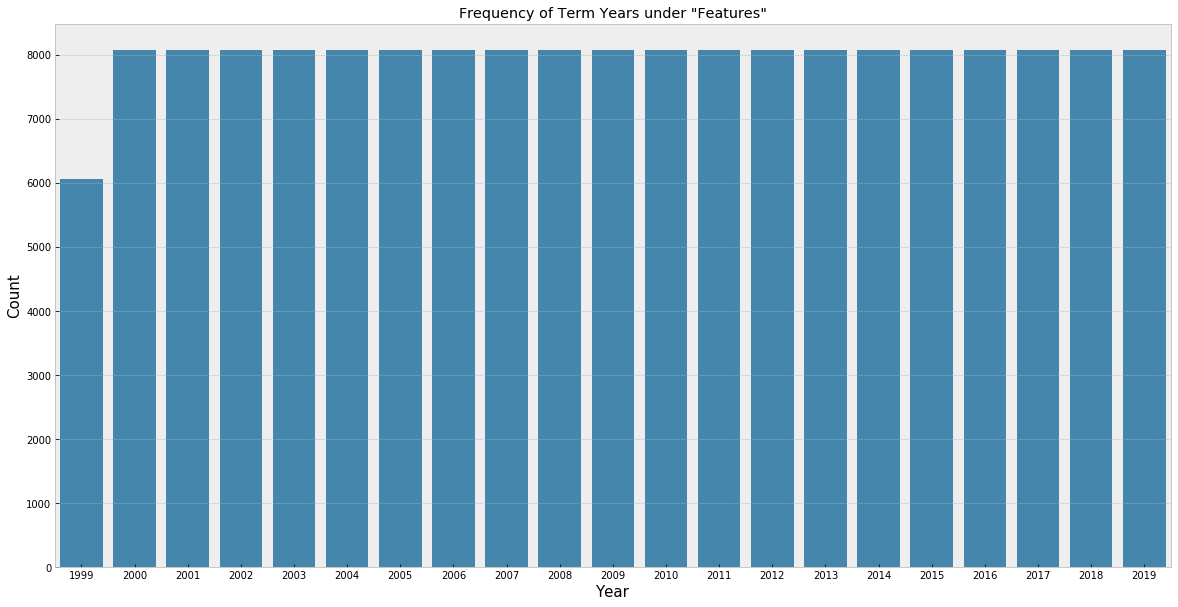

In [311]:
#years
plt.figure(figsize = [20, 10])

ax = sb.countplot(data = features, x = features.term.dt.year, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Term Years under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-years-count.png')
plt.show();

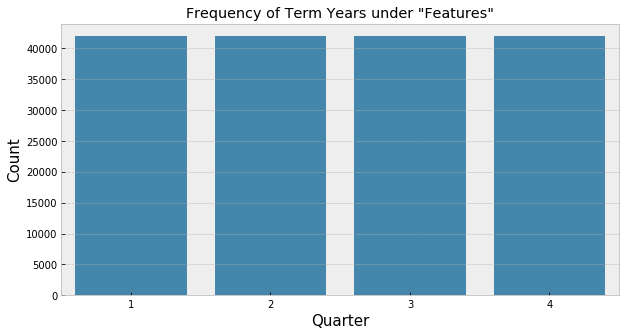

In [312]:
#quarter
#years
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features.term.dt.quarter, color = sb.color_palette()[0])
ax.set(xlabel = 'Quarter', ylabel = 'Count')
ax.set_title('Frequency of Term Years under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-quarters-count.png')
plt.show();

**Observation 1:** There is a consistent number of ***quarters*** under **term**, unlike years.

**Observation 2:** For years, all counts are consistent except for the year 1999, whose count is significantly less than each other one, individually. TK this is because the year 1999 isn't included in the DataFrame TK.

### VALUE (Features)

In [356]:
def generate_hist(df, x, bins, title, xlabel, ylabel, save_path, csv_name):
    plt.figure(figsize = [14, 7])
    
    plt.hist(data = df, x = x, bins = bins, color = 'palevioletred')
    plt.title(title, size = 25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.savefig(save_path + csv_name)

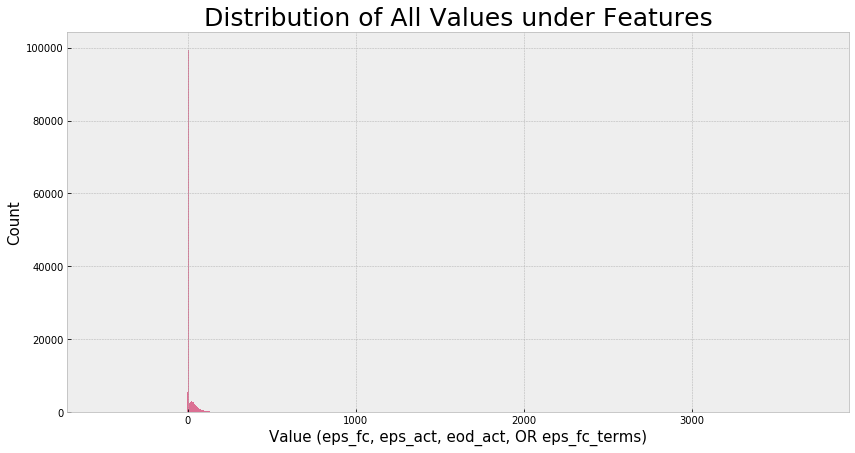

In [357]:
value_bins = np.arange(-505, features.value.max() + 5, 5)
generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist.png')

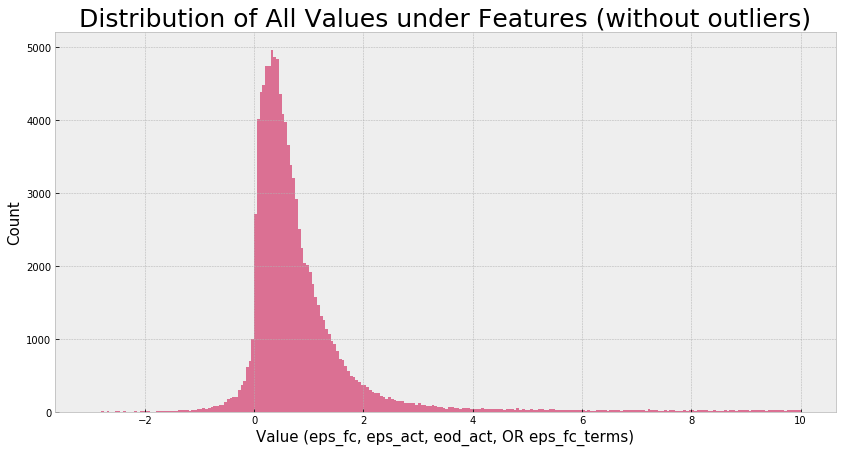

In [358]:
value_bins = np.arange(-3, 10 + 0.05, 0.05)
value_hist = generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features (without outliers)', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist-zoom.png')

**Observation 1:** It appears to be a normal distribution with a ***heavy left skew.*** 

But just to make sure it is skewed heavily to the left, let's create a kernel density curve:


In [360]:
from scipy.stats import norm

def generate_distplot(data, bins, ):
    fig = plt.figure(figsize = [14, 7])
    ax = sb.distplot(data, bins = bins, color = 'hotpink')
    ax.minorticks_on()
    return fig, ax

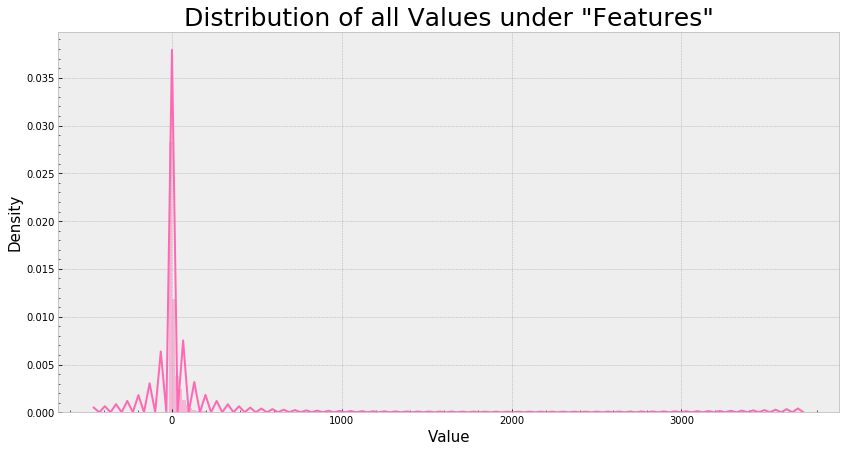

In [359]:
value_bins = np.arange(features.value.min(), features.value.max() + 20, 20)
generate_distplot(features.value.dropna(), bins = value_bins)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of all Values under "Features"', size = 25);
plt.savefig(PATH_UNIVARIATE + 'features')

### FIRM_ID (Averages)

### AVERAGE (Averages)

### AVERAGE TYPE (Averages)

### TIME_PERIOD (Averages)

### FEATURE (Averages)

## IV) Bivariate Exploration<a id = "bi"></a>

## V) Multivariate Exploration <a id="multi"></a>